## QPIE

Here we tried to encode the image and get it back using the QPIE algorithm that we found in the Quiskit book at: \
https://qiskit.org/textbook/ch-applications/quantum-edge-detection.html

In [1]:
# Importing standard Qiskit libraries and configuring account.
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import utils_IONqchallenge
style.use('bmh')

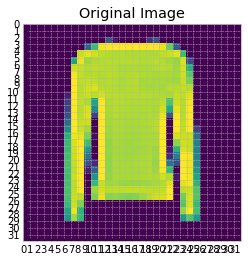

In [15]:
# Define the path to the dataset and chose an image as example.
path = "data/images.npy"
data = np.load(path)

np.random.seed(45)
idx = np.random.randint( 0 , len(data) , dtype = int )
try_image = np.array(data[idx])

# Make the number of pixels in the image a power of 2.
try_image = np.pad( try_image , ((2, 2), (2, 2)), 'constant', constant_values = ( ( 0 , 0 ) , ( 0 , 0 ) ) )

# Plot the image as example.
utils_IONqchallenge.plot_image( try_image, 'Original Image')

- Now we use the QPIE algorithm found in the book to encode the image in a quantm state vector. 

In [16]:
# Get the amplitude ancoded pixel values.

# Horizontal: Original image
image_norm_h = utils_IONqchallenge.amplitude_encode(try_image)
# Vertical: Transpose of Original image
image_norm_v = utils_IONqchallenge.amplitude_encode(try_image.T)

- And we initialize a quantum circuit with these information.

In [17]:
# Initialize some global variable for number of qubits
data_qb = 10
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll( np.identity( 2 ** total_qb ) , 1 , axis = 1 )

In [18]:
# Create the circuit for horizontal scan.
qc_h = QuantumCircuit( total_qb )
qc_h.initialize( image_norm_h , range( 1 , total_qb ) )
qc_h.h(0)
qc_h.unitary( D2n_1 , range(total_qb) )
qc_h.h(0)

# Create the circuit for vertical scan.
qc_v = QuantumCircuit( total_qb )
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary( D2n_1 , range(total_qb) )
qc_v.h(0)

# Combine both circuits into a single list
circ_list = [ qc_h , qc_v ]

In [19]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend = back ).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

In [20]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

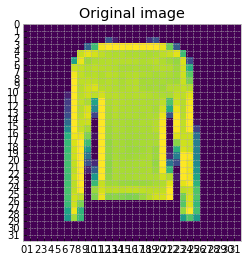

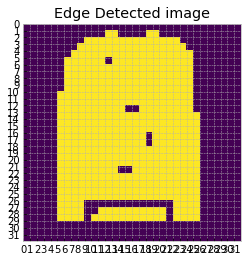

In [21]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
utils_IONqchallenge.plot_image(try_image, 'Original image')
utils_IONqchallenge.plot_image(edge_scan_sim, 'Edge Detected image')